# SnapATAC Peak Matrix Analysis

Using data processed by Laksshman, pmat using peaks from day-wise bulk + cluster-wise bulk combined.

Similar to Pmat.ipynb but instead looks at two or few days at a time.

**NOTE**: As of 6 Feb, the pmat are attached to snap files only at `/srv/scratch`. Moreover, the pmat attached using SnapTools most likely counts fragments in peaks. For correctness, we should count Tn5 shifted 5' ends of reads in peaks.

In [1]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapp

In [116]:
# DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")
DAYS = c("D0", "D2", "D4", "D6")
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"
BARCODES_PREFIX = "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8"

file.list = c()
barcode.file.list = c()

for (d in DAYS) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}
DAYS
file.list
barcode.file.list

[1] "D0" "D2" "D4" "D6"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap"
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap"
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap"
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap"

[1] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D0.barcodes.txt"
[2] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D2.barcodes.txt"
[3] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D4.barcodes.txt"
[4] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D6.barcodes.txt"

In [117]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [118]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [119]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [120]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [121]:
x.sp

number of barcodes: 40342
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [122]:
dim(x.sp@pmat)

[1]  40342 467339

In [123]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10974753,586.2,26748501,1428.6,26748501,1428.6
Vcells,641732110,4896.1,2396656483,18285.1,2889172938,22042.7


In [124]:
x.sp = makeBinary(x.sp, mat="pmat");

In [125]:
tempCov = Matrix::rowSums(x.sp@pmat)

In [126]:
# remove UMIs with few bins
x.sp = x.sp[tempCov>1000, , mat="pmat"]
x.sp

number of barcodes: 37890
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [127]:
# sampling few cells for speed (simplified analysis)
# sample_idx = sort(sample(seq(1,dim(x.sp@bmat)[1]), 10000))
# x.sp = x.sp[sample_idx,]
# x.sp

In [128]:
# OR keeping the same number of cells from each day
# fewest_per_day = min(table(x.sp@sample)) # TAKING HALVE
# print(fewest_per_day)

# idxs = c()
# for (d in DAYS) {
#     idxs = c(idxs, sample(which(x.sp@sample==d), fewest_per_day))
# }
# idxs = sort(idxs)

# table(x.sp@sample[idxs])

# x.sp = x.sp[idxs, ]

In [129]:
x.sp

number of barcodes: 37890
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

## Filtering bins

In [130]:
black_list = read.table("../20200122_snapATAC/data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [131]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [132]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [133]:
# chr.exclude = seqlevels(x.sp@peak)[grep("random|chrM|chrUn", seqlevels(x.sp@peak))];
# idy = grep(paste(chr.exclude, collapse="|"), x.sp@peak);
# if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [134]:
x.sp

number of barcodes: 37890
number of bins: 0
number of genes: 0
number of peaks: 467336
number of motifs: 0

number of barcodes: 37890
number of bins: 0
number of genes: 0
number of peaks: 436088
number of motifs: 0

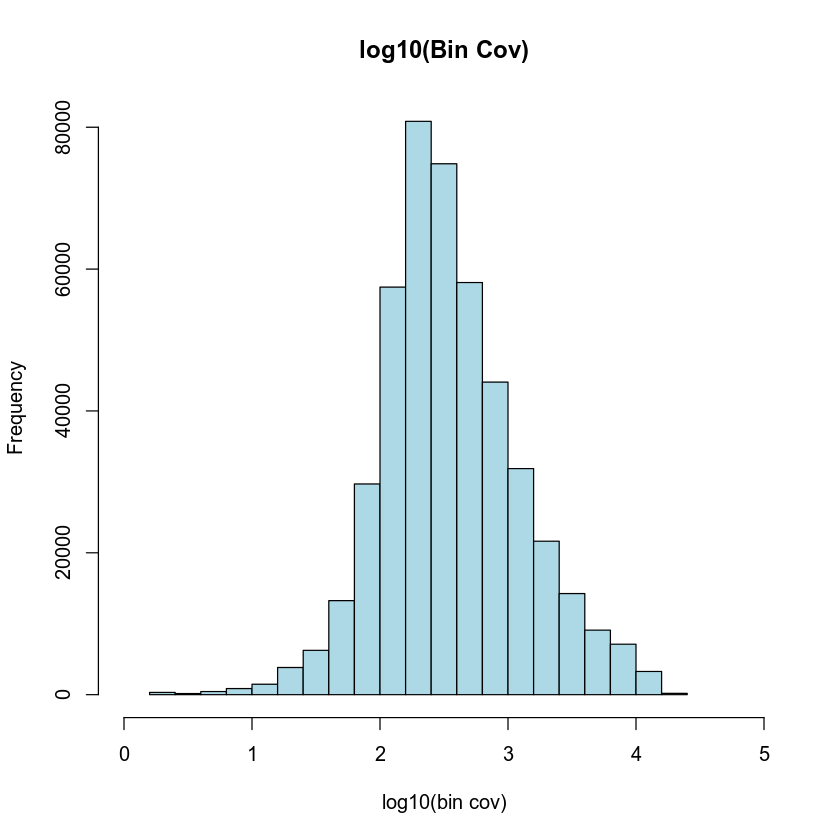

In [135]:
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

## Dim Reduction

In [136]:
rowCovs = Matrix::rowSums(x.sp@pmat)

In [137]:
row.covs = log10(rowCovs+1);
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [138]:
set.seed(1);
idx.landmark.ds = sort(sample(x = seq(nrow(x.sp)), size = 10000, prob = sampling_prob));
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [139]:
table(x.landmark.sp@sample)


  D0   D2   D4   D6 
2615 2639 2183 2563 

In [140]:
# DOES NOT WORK OUT OF THE BOX SINCE bmat is hardcoded in trainRegression
# x.landmark.sp = runDiffusionMaps(
#     obj= x.landmark.sp,
#     input.mat="pmat", 
#     num.eigs=50
# );

In [141]:
# modifying internal functions to make them work for pmat -- buggy now

myTrainRegression <- function(obj){
        row.covs = log(Matrix::rowSums(obj@pmat)+1,10); # EDITED THIS FROM bmat TO pmat
        row.covs.dens <- density(x = row.covs, bw = 'nrd', adjust = 1)
        sampling_prob <- 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps)
        idx.ds <- sort(sample(x = seq(row.covs), size = min(1000, length(row.covs)), prob = sampling_prob));
        jmat.tr = obj@jmat@jmat[idx.ds,idx.ds];
        b1.tr = obj@jmat@p1[idx.ds];
        b2.tr = obj@jmat@p2[idx.ds];
        # calculate the expected jaccard index matrix given the read depth
        emat.tr = SnapATAC:::.normOVE(b1.tr, b2.tr);
        # estimate the global scaling factor
        data = data.frame(x=emat.tr[upper.tri(emat.tr)], y=jmat.tr[upper.tri(jmat.tr)])	
        model <- lm(y ~ x + I(x^2), data);
        beta0 = as.numeric(model$coefficients)[1]
        beta1 = as.numeric(model$coefficients)[2]
        beta2 = as.numeric(model$coefficients)[3]
        obj@regModel = c(beta0, beta1, beta2);
        rm(jmat.tr);
        rm(emat.tr);
        rm(data);
        rm(model);
        rm(row.covs);
        return(obj)
}


myRunDiffusionMaps <- function(
        obj,
        input.mat=c("bmat", "pmat"), 
        num.eigs=20
){
    nmat.outlier = 0.999
    
    message("Epoch: computing jaccard similarity matrix ...");
    obj = SnapATAC:::runJaccard2(obj, obj, input.mat=input.mat);
    
    message("Epoch: fitting regression model ...");
    obj = myTrainRegression(obj);
    
    message("Epoch: performing normalization ...");
    obj = SnapATAC:::normJaccard(obj, obj@regModel[1], obj@regModel[2], obj@regModel[3]);
    
    # remove the outliers
    nmat.cutoff = quantile(obj@jmat@nmat, nmat.outlier);
    obj@jmat@nmat[obj@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: computing eigen decomposition ...");
    obj = SnapATAC:::runEigDecomp(obj, num.eigs);

    obj@smat@method = "DiffusionMaps";
    message("Epoch: Done");
    return(obj);
}

myRunDiffusionMapsExtension <- function(
        obj1,
        obj2,
        input.mat=c("bmat", "pmat")
){
    data.use.qry = obj2@pmat;
    peak.use.qry = obj2@peak;
        
    message("Epoch: computing jaccard similarity matrix ...");
    obj2 = SnapATAC:::runJaccard2(obj2, obj1, input.mat=input.mat);

    message("Epoch: performing normalization ...");
    obj2 = SnapATAC:::normJaccard(obj2, obj1@regModel[1], obj1@regModel[2], obj1@regModel[3])

    # remove the outliers
    nmat.cutoff = max(obj1@jmat@nmat);
    obj2@jmat@nmat[obj2@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: projecting query cells to the reference ...");
    obj2 = SnapATAC:::runEigDecompExd(obj1, obj2);
    
    message("Epoch: Done");
    obj2@pmat = data.use.qry
    obj2@peak = peak.use.qry
    
    return(obj2);
}

In [142]:
x.landmark.sp = myRunDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="pmat", 
    num.eigs=50
);

Epoch: computing jaccard similarity matrix ...

Epoch: fitting regression model ...

Epoch: performing normalization ...

Epoch: computing eigen decomposition ...

Epoch: Done



In [ ]:
x.query.sp = myRunDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="pmat"
  );

Epoch: computing jaccard similarity matrix ...



In [ ]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT
rm(x.landmark.sp, x.query.sp); # free memory

# IMP: recompute since order has changed
rowCovs = Matrix::rowSums(x.sp@pmat)

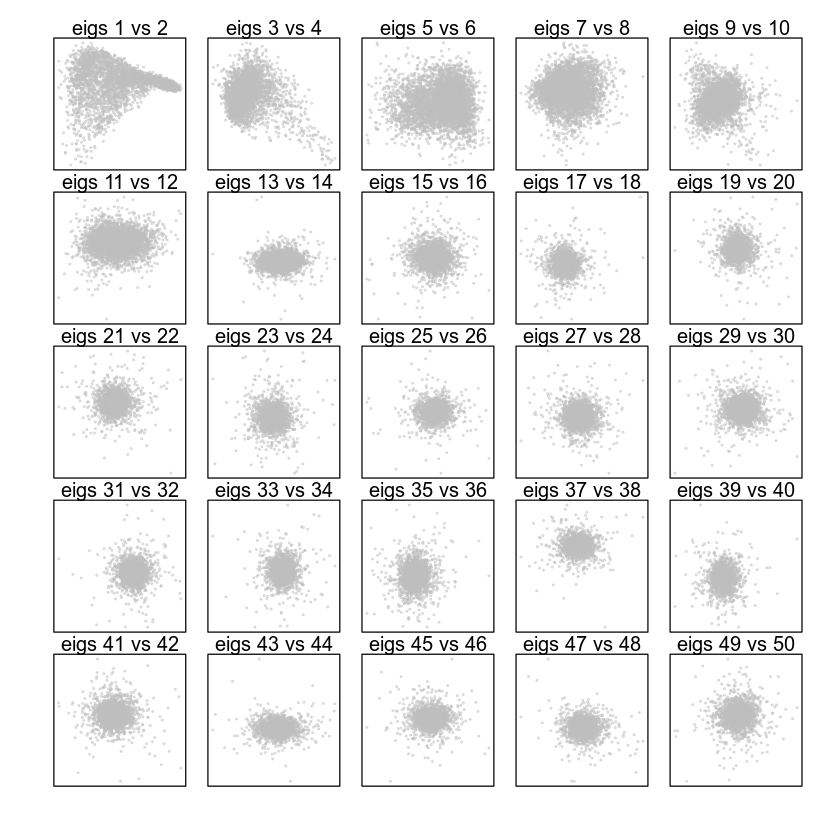

In [201]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [ ]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:10,
    k=15
  );

In [ ]:
library(leiden)

In [ ]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   seed.use=9
);
x.sp@metaData$cluster = x.sp@cluster;

In [ ]:
table(x.sp@cluster)

In [202]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:12, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

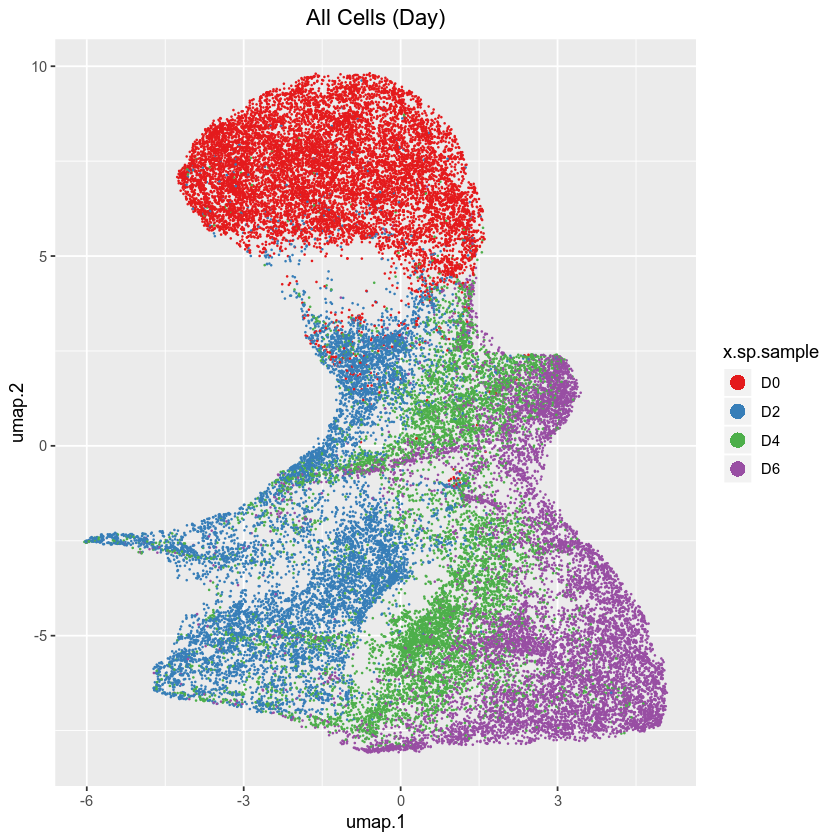

In [203]:
df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

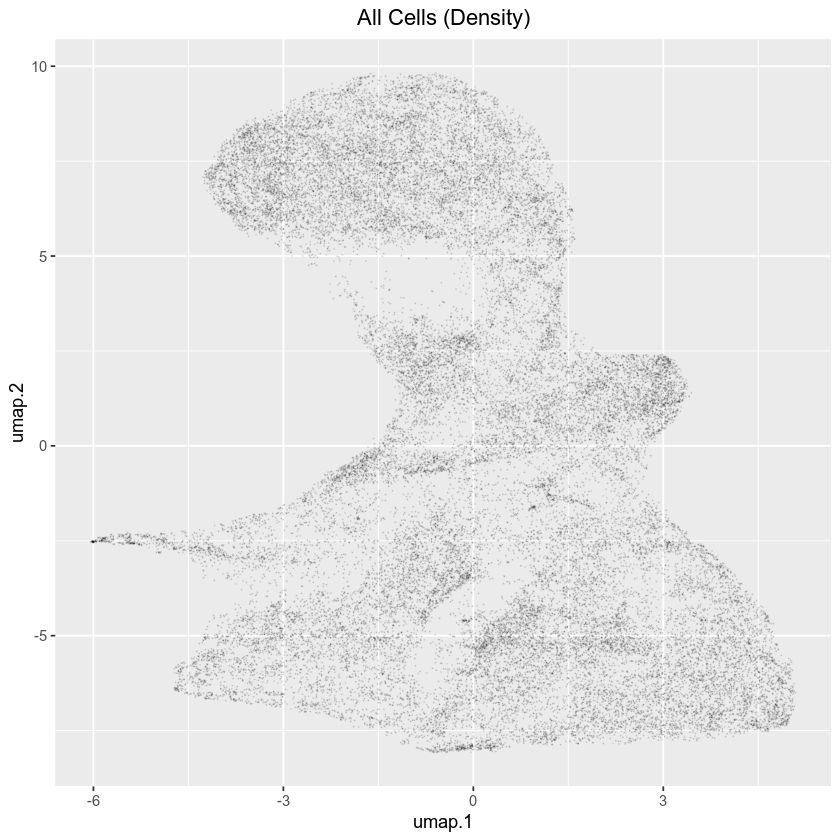

In [204]:
df = data.frame(x.sp@umap, x.sp@sample)

ggplot(df) +
geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
ggtitle("All Cells (Density)") + 
theme(plot.title = element_text(hjust = 0.5)) 

In [172]:
table(x.sp@sample[x.sp@cluster=="11"])


D10 D12 D14  D2  D4  D6  D8 
 10  23   7   1  60 668  81 

In [196]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@peak, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@pmat[,idy]) / Matrix::rowSums(x.sp@pmat);

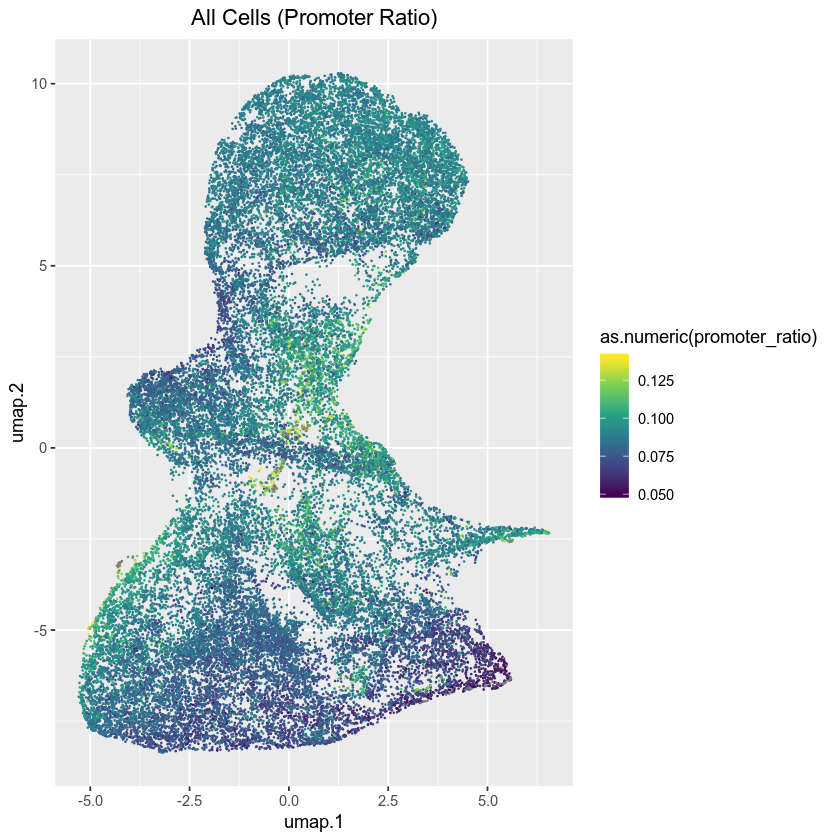

In [200]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(lim=c(0.05,0.14)) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

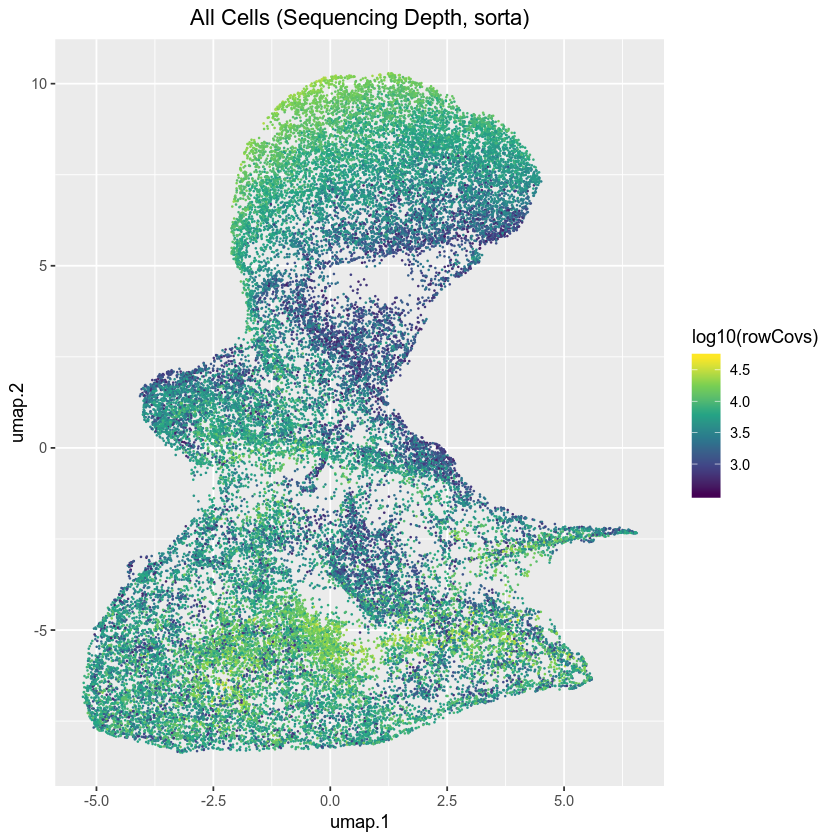

In [195]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

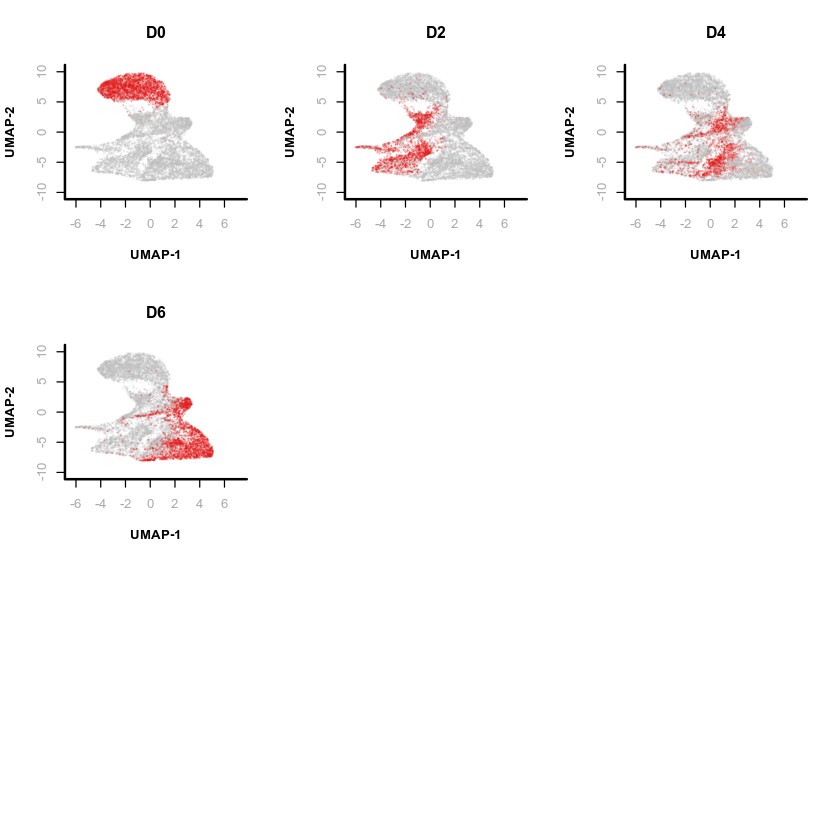

In [210]:
par(mfrow = c(3, 3));
for(d in DAYS){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

## ChromVar

In [ ]:
library(chromVAR)
library(motifmatchr)
library(SummarizedExperiment);
library(BSgenome.Hsapiens.UCSC.hg38);
library(JASPAR2016)

In [ ]:
x.sp@mmat = runChromVAR(
    obj=x.sp,
    input.mat="pmat",
    genome=BSgenome.Hsapiens.UCSC.hg38,
    min.count=10,
    species="Homo sapiens"
  );

In [41]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

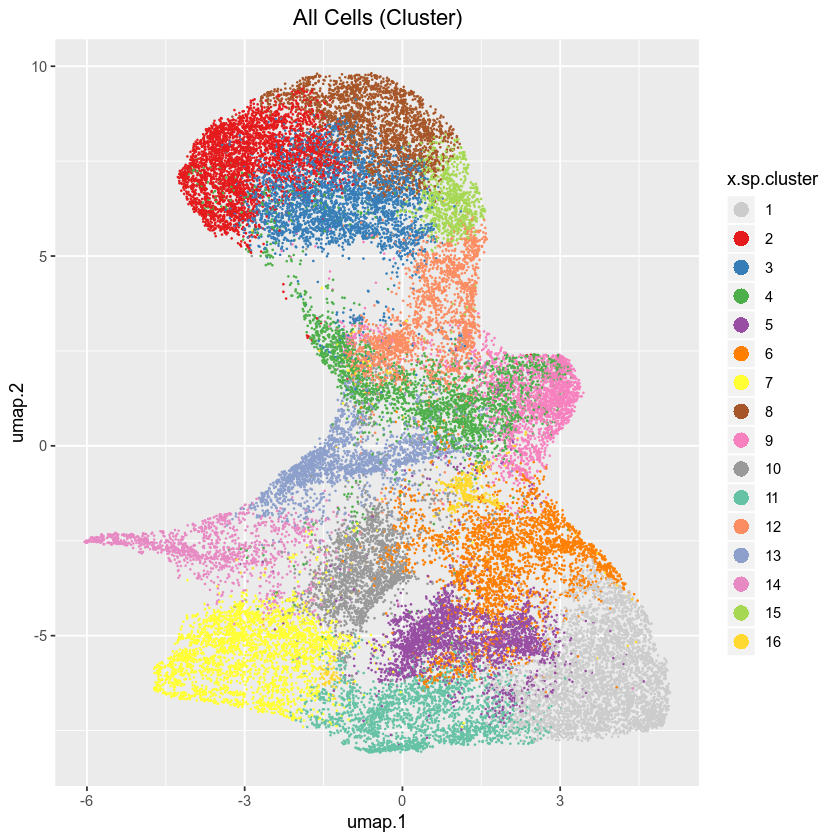

In [205]:
df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.1, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [180]:
table(x.sp@sample[x.sp@cluster=="11"])


 D2  D4  D6 
140 991 994 

In [207]:
df = data.frame(x.sp@umap, x.sp@mmat, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

In [211]:
colnames(df)[grep("POU5", colnames(df))]

[1] "MA0792.1_POU5F1B"

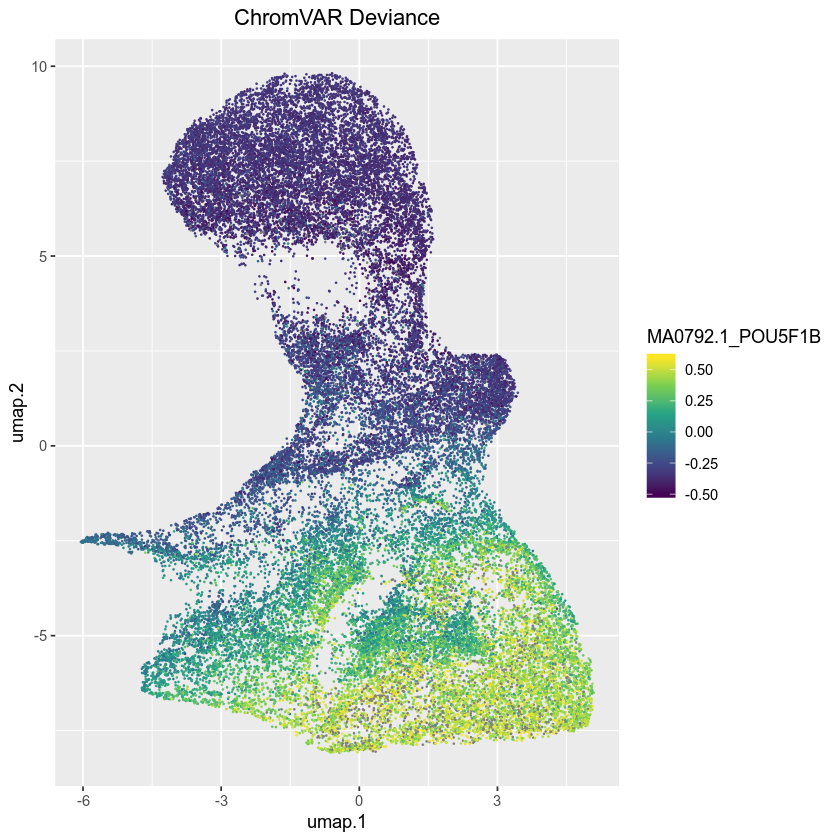

In [212]:
ggplot(df, aes(x=umap.1, y=umap.2, col=MA0792.1_POU5F1B)) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.6)) +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 

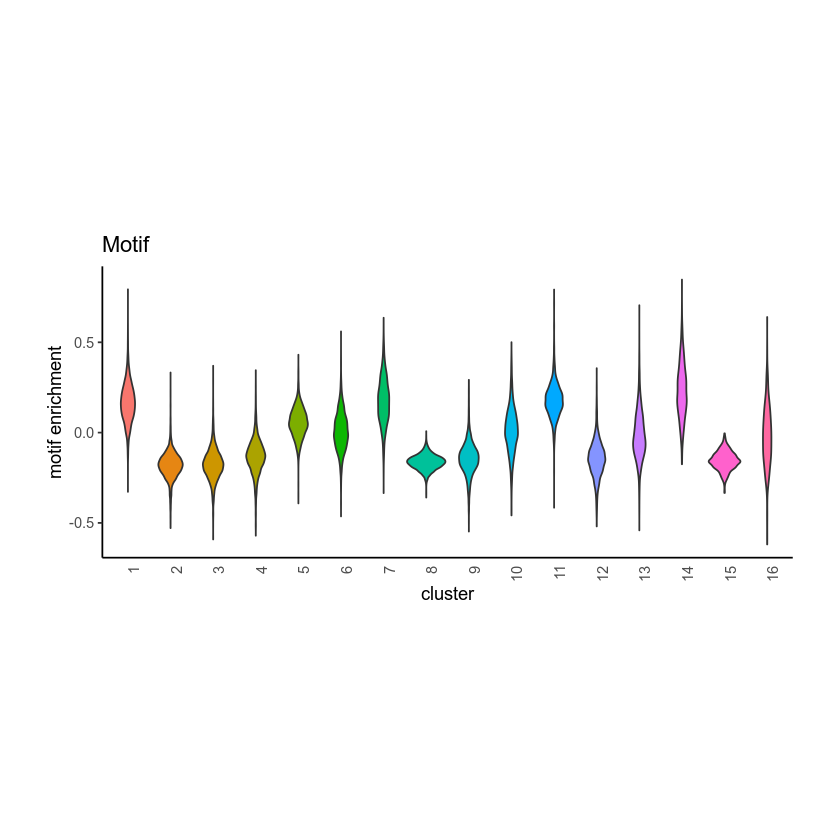

In [169]:
ggplot(df, aes(x=x.sp.cluster, y= MA0801.1_MGA, fill=x.sp.cluster)) + 
    theme_classic() +
    geom_violin() + 
    xlab("cluster") +
    ylab("motif enrichment") + 
    ggtitle("Motif") +
    theme(
          plot.margin = margin(5,1,5,1, "cm"),
          axis.text.x = element_text(angle = 90, hjust = 1),
          axis.ticks.x=element_blank(),
          legend.position = "none"
);

In [161]:
by_cluster = aggregate(x.sp@mmat,  list(x.sp@cluster), mean)

In [185]:
max_for_cluster = by_cluster[,apply(by_cluster, 2, which.max)=="9"]
colnames(max_for_cluster)

[1] "MA0030.1_FOXF2"   "MA0031.1_FOXD1"   "MA0101.1_REL"     "MA0107.1_RELA"   
 [5] "MA0481.1_FOXP1"   "MA0148.3_FOXA1"   "MA0593.1_FOXP2"   "MA0613.1_FOXG1"  
 [9] "MA0042.2_FOXI1"   "MA0033.2_FOXL1"   "MA0157.2_FOXO3"   "MA0652.1_IRF8"   
[13] "MA0653.1_IRF9"    "MA0684.1_RUNX3"   "MA0692.1_TFEB"    "MA0511.2_RUNX2"  
[17] "MA0839.1_CREB3L1" "MA0846.1_FOXC2"   "MA0847.1_FOXD2"   "MA0848.1_FOXO4"  
[21] "MA0849.1_FOXO6"   "MA0850.1_FOXP3"

In [176]:
colnames(max_for_cluster)[rev(order(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))]

[1] "MA0713.1_PHOX2A"       "MA0639.1_DBP"          "MA0689.1_TBX20"       
 [4] "MA0688.1_TBX2"         "MA0752.1_ZNF410"       "MA0800.1_EOMES"       
 [7] "MA0690.1_TBX21"        "MA0802.1_TBR1"         "MA0043.2_HLF"         
[10] "MA0875.1_BARX1"        "MA0899.1_HOXA10"       "MA0901.1_HOXB13"      
[13] "MA0465.1_CDX2"         "MA0706.1_MEOX2"        "MA0634.1_ALX3"        
[16] "MA0866.1_SOX21"        "MA0707.1_MNX1"         "MA0909.1_HOXD13"      
[19] "MA0724.1_VENTX"        "MA0768.1_LEF1"         "MA0523.1_TCF7L2"      
[22] "MA0893.1_GSX2"         "MA0868.1_SOX8"         "MA0610.1_DMRT3"       
[25] "MA0867.1_SOX4"         "MA0084.1_SRY"          "MA0905.1_HOXC10"      
[28] "MA0908.1_HOXD11"       "MA0471.1_E2F6"         "MA0714.1_PITX3"       
[31] "MA0527.1_ZBTB33"       "MA0479.1_FOXH1"        "MA0895.1_HMBOX1"      
[34] "MA0508.1_PRDM1"        "MA0130.1_ZNF354C"      "MA0528.1_ZNF263"      
[37] "MA0635.1_BARHL2"       "MA0907.1_HOXC13"       "MA0772.1_IRF7"        
[40] "MA0051.1_IRF2"         "MA0050.2_IRF1"         "MA0906.1_HOXC12"      
[43] "MA0651.1_HOXC11"       "MA0712.1_OTX2"         "MA0517.1_STAT1::STAT2"
[46] "MA0873.1_HOXD12"       "MA0496.1_MAFK"

In [177]:
data.frame(rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min))))

,rev.sort.apply.max_for_cluster..2..max....apply.max_for_cluster..
,<dbl>
MA0713.1_PHOX2A,0.34016996
MA0639.1_DBP,0.32784027
MA0689.1_TBX20,0.29946370
MA0688.1_TBX2,0.29084092
MA0752.1_ZNF410,0.28981566
MA0800.1_EOMES,0.28358692
MA0690.1_TBX21,0.28336191
MA0802.1_TBR1,0.27933527
MA0043.2_HLF,0.27072086


## Export Meta Data for Session (UNTESTED FOR pmat)

In [172]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./snapATAC_sessions/20200125_n76770/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))

Warning message in file(file, ifelse(append, "a", "w")):
“cannot open file './snapATAC_sessions/20200125_n76770/metadata.tsv': No such file or directory”


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


In [ ]:
write.table(x.sp@smat@dmat, "./snapATAC_sessions/20200125_n76770/eig_mat.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [74]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp@feature),
                       starts=start(x.sp@feature)-1,
                       ends=end(x.sp@feature)),
            file="./snapATAC_sessions/20200125_n76770/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [16]:
writeMM(x.sp@bmat, file="./snapATAC_sessions/20200125_n76770/5kb.sparse.mm")

NULL

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL